In [303]:
from SAEM import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt

In [304]:
def sigma(x):
    return 1 / (1 + np.exp(-x))

def toep(d, rate):
    return np.array([[(rate) ** abs(i - j) for i in range(d)] for j in range(d)])

def generate_X(d, corr_rate, n, prop=None, beta0=None, limit=0.005, max_iter=100, intercept=0):
    cov = toep(d, corr_rate)
    X = np.random.multivariate_normal(np.zeros(d), cov, size=n)

    center_X = np.zeros(d)

    if prop is not None:
        for _ in range(max_iter):
            y_attempt = sigma(X @ beta0 + intercept)
            y_drawn = np.random.binomial(1, y_attempt)
            current_prop = np.mean(y_drawn)

            if np.abs(current_prop - prop) < limit:
                break

            # Adaptive step size with Newton-like update
            step_size = np.clip((prop - current_prop) / (current_prop * (1 - current_prop) + 1e-6), -0.5, 0.5)
            X += step_size * beta0  # Faster convergence
            center_X += step_size * beta0
        
    return X, center_X

In [305]:
n = 2000
d = 3

corr_rate = 0.85

X, _ = generate_X(d=d, corr_rate=corr_rate, n=n)
M = generate_mask(n, d, 0.75)

beta = np.random.uniform(-1, 1, d)*2
y_logits = X @ beta
y_probs = sigma(y_logits)
y = np.random.binomial(1, y_probs)

X_obs = X.copy()
X_obs[M == 1] = np.nan
print(beta)

[-1.31332369 -1.04917055  0.33720538]


In [306]:
pysaem = MissGLM(var_cal=False)

pysaem.fit(X_obs, y, save_trace=True)

 39%|███▉      | 196/500 [02:21<03:39,  1.39it/s]

...converged after 197 iterations.


MissGLM(subsets=array([0, 1, 2]), var_cal=False)

In [307]:
ntest = 500

X_test, _ = generate_X(d=d, corr_rate=corr_rate, n=ntest)
M_test = generate_mask(ntest, d, 0.35)
X_test_obs = X_test.copy()
X_test_obs[M_test == 1] = np.nan
y_logits_test = X_test @ beta
y_probs_test = sigma(y_logits_test)
y_test = np.random.binomial(1, y_probs_test)


y_test_pred = pysaem.predict_proba(X_test_obs, "map")[:,1]

here


In [308]:
y_probs_bayes = get_y_prob_bayes(X_test_obs, np.zeros(d), toep(d, corr_rate), beta, n_mc=200).mean(axis=1)

In [314]:
idx = get_index_pattern(1, M_test)

y_test_pred_idx = y_test_pred[idx]
y_test_idx = y_test[idx]
y_probs_test_idx = y_probs_test[idx]
y_probs_bayes_idx = y_probs_bayes[idx]

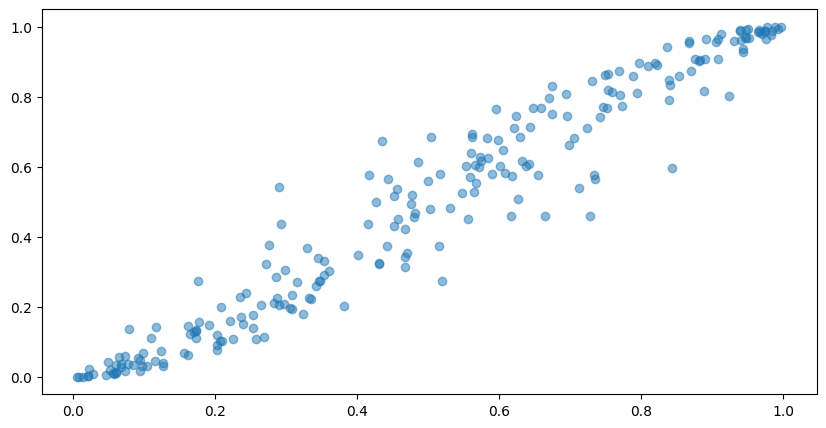

In [315]:
plt.figure(figsize=(10, 5))
plt.scatter(y_probs_bayes_idx, y_test_pred_idx, alpha=0.5)

In [316]:
pysaem.sigma_

array([[1.01833976, 0.1925151 , 0.12939394],
       [0.1925151 , 1.00411676, 0.15099643],
       [0.12939394, 0.15099643, 1.00263741]])

In [317]:
Xstar, _ = generate_X(d=d, corr_rate=corr_rate, n=1000)
np.cov(Xstar, rowvar=False) * (n - 1) / n

array([[1.02967193, 0.85876785, 0.74952026],
       [0.85876785, 1.01411765, 0.88690621],
       [0.74952026, 0.88690621, 1.05856672]])

In [ ]:
# 2-dim
# => no corr    => perfect
# => corr=0.85  => underestimate covariance (for d = 3, weird when d=2)